First download the list 

In [10]:
import requests
import os

dir_path = os.getcwd()

lista_finale_post_script_csv = os.path.join(dir_path, "lista_finale_post_script.csv")
lista_finale_csv = os.path.join(dir_path, "lista_finale.csv")

# Construct the URL for exporting the sheet in CSV format
lista_finale_post_script_URL = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=2002066435"
lista_finale_url = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=92667368"


try:
  # Download the lista finale post script 3
  response = requests.get(lista_finale_post_script_URL)
  response.raise_for_status()
  with open(lista_finale_post_script_csv, "wb") as file:
    file.write(response.content)
  print(f"Lista finale downloaded successfully and saved")

  # Download the lista finale
  response = requests.get(lista_finale_url)
  response.raise_for_status()
  with open(lista_finale_csv, "wb") as file:
    file.write(response.content)
  print(f"Lista finale downloaded successfully and saved")

except requests.exceptions.RequestException as e:
  print(f"Error downloading the Google Sheet: {e}")

Lista finale downloaded successfully and saved
Lista finale downloaded successfully and saved


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

KEY_URL_PROGETTO = "URL progetto"
SITO_FUNZIONANTE = "Sito funzionante"
SITO_NON_TROVATO = "Sito non trovato"
SITO_NON_FUNZIONANTE = "Sito non funzionante"
SITO_NON_REINDERIZZATO = "Sito non reinderizzato"
SITO_PARZIALMENTE_INACCESSIBILE = "Sito parzialmente Inacessibile"

KEY_URL_PROGETTO_FIRST_SEEN = "URL progetto First_Seen"
KEY_URL_PROGETTO_LAST_SEEN = "URL progetto Last_Seen"

data = pd.read_csv(lista_finale_csv)
data_with_dates = pd.read_csv(lista_finale_post_script_csv)

# Add timestamp columns
for index, row in data.iterrows():
  url_progetto = row[KEY_URL_PROGETTO]
  if pd.notna(url_progetto):
    matching_rows = data_with_dates[data_with_dates[KEY_URL_PROGETTO] == url_progetto]
    if not matching_rows.empty:
      first_seen = matching_rows[KEY_URL_PROGETTO_FIRST_SEEN].min()
      last_seen = matching_rows[KEY_URL_PROGETTO_LAST_SEEN].max()
      data.at[index, KEY_URL_PROGETTO_FIRST_SEEN] = first_seen
      data.at[index, KEY_URL_PROGETTO_LAST_SEEN] = last_seen

print(f"Number of projects: {data.shape[0]}\n")
print(f"Number of projects with functioning website: {data[data[SITO_FUNZIONANTE] == True].shape[0]}")
print(f"Number of projects with partially inaccessible website: {data[data[SITO_PARZIALMENTE_INACCESSIBILE] == True].shape[0]}\n")
print(f"Number of projects with unavailable website: {data[data[SITO_NON_TROVATO] == True].shape[0]}")
print(f"Number of projects with non-functioning website: {data[data[SITO_NON_FUNZIONANTE] == True].shape[0]}")
print(f"Number of projects with non-redirected website: {data[data[SITO_NON_REINDERIZZATO] == True].shape[0]}")

dataset1 = os.path.join(dir_path, "dataset_1.csv")
data.to_csv(dataset1, index=False)
data.to_csv(os.path.join(os.pardir, "dataset_1.csv"), index=False)

print(f"Dataset saved")

Number of projects: 262

Number of projects with functioning website: 206
Number of projects with partially inaccessible website: 31

Number of projects with unavailable website: 20
Number of projects with non-functioning website: 26
Number of projects with non-redirected website: 11
Dataset saved


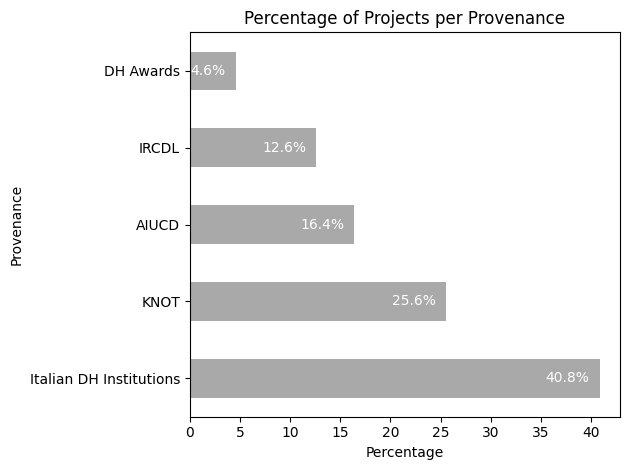

In [12]:
# Calculate the percentage of projects per provenance
provenance_counts = data['Provenance'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart
fig, ax = plt.subplots()
bars = provenance_counts.plot(kind='barh', ax=ax, color='darkgrey')
ax.set_title('Percentage of Projects per Provenance')
ax.set_xlabel('Percentage')
ax.set_ylabel('Provenance')
plt.tight_layout()

for bar in bars.patches:
  ax.text(bar.get_width() - 1, bar.get_y() + bar.get_height() / 2,
      f'{bar.get_width():.1f}%', va='center', ha='right', color='white', fontsize=10)

plt.show()

In [4]:
unavailable_projects = data[(data[SITO_NON_TROVATO] == False) & (data[SITO_FUNZIONANTE] == False)]

print(f"Projects with unavailable website: {unavailable_projects.shape[0]}")

dataset2 = os.path.join(dir_path, "dataset_2.csv")

unavailable_projects.to_csv(dataset2, index=False, escapechar='\\', quoting=1)
unavailable_projects.to_csv(os.path.join(os.pardir, "dataset_2.csv"), index=False, escapechar='\\', quoting=1)
print(f"Dataset saved")


Projects with unavailable website: 36
Dataset saved


In [13]:
# Define the URL and file path for the new dataset
new_dataset_url = "https://docs.google.com/spreadsheets/d/1G3WiRMoopP8Y2FlVJfwCRqZVLilw-aMQRBxF_SoMF20/export?format=csv&gid=894427287"
new_dataset_csv = os.path.join(dir_path, "unavailable_projects.csv")

try:
  # Download the new dataset
  response = requests.get(new_dataset_url)
  response.raise_for_status()
  with open(new_dataset_csv, "wb") as file:
    file.write(response.content)
  print(f"New dataset downloaded successfully and saved")

except requests.exceptions.RequestException as e:
  print(f"Error downloading the new dataset: {e}")
  
# Load the new dataset
new_data = pd.read_csv(new_dataset_csv)

# Update the 'URL progetto Last_Seen' column in the original data
for index, row in new_data.iterrows():
  correct_last_seen = row.get("CORRECT LAST SEEN")
  url_progetto = row.get(KEY_URL_PROGETTO)
  if pd.notna(correct_last_seen) and pd.notna(url_progetto):
    data.loc[data[KEY_URL_PROGETTO] == url_progetto, KEY_URL_PROGETTO_LAST_SEEN] = correct_last_seen

# Save the updated dataset
dataset3 = os.path.join(dir_path, "dataset_3.csv")
data.to_csv(dataset3, index=False)
data.to_csv(os.path.join(os.pardir, "dataset_final.csv"), index=False)

New dataset downloaded successfully and saved


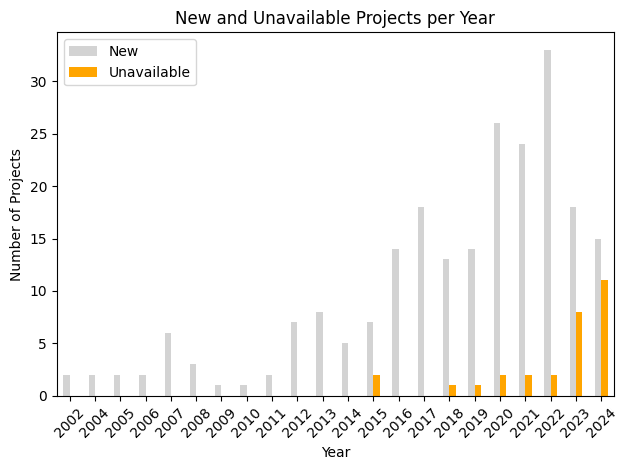

In [14]:
# Extract the year from the 'First_Seen' and 'Last_Seen' columns
data[KEY_URL_PROGETTO_FIRST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_FIRST_SEEN], errors='coerce')
data[KEY_URL_PROGETTO_LAST_SEEN] = pd.to_datetime(data[KEY_URL_PROGETTO_LAST_SEEN], errors='coerce')
data['Year_First_Seen'] = data[KEY_URL_PROGETTO_FIRST_SEEN].dt.year
data['Year_Last_Seen'] = data[KEY_URL_PROGETTO_LAST_SEEN].dt.year

# Calculate new projects
new_projects = data['Year_First_Seen'].value_counts().sort_index()

# Calculate unavailable projects
unavailable_projects = data[(data[KEY_URL_PROGETTO_LAST_SEEN].notna()) & (data[SITO_FUNZIONANTE] == False)]['Year_Last_Seen'].value_counts().sort_index()

# Create a DataFrame for plotting
years = sorted(set(new_projects.index).union(set(unavailable_projects.index)))
new_counts = [new_projects.get(year, 0) for year in years]
unavailable_counts = [unavailable_projects.get(year, 0) for year in years]

df_years = pd.DataFrame({
  'Year': years,
  'New': new_counts,
  'Unavailable': unavailable_counts
})

# Convert 'Year' column to integer for better readability on x-axis
df_years['Year'] = df_years['Year'].astype(int)

# Plot the bar chart
fig, ax = plt.subplots()
df_years.plot(kind='bar', x='Year', y=['New', 'Unavailable'], ax=ax, color=['lightgrey', 'orange'])
ax.set_title('New and Unavailable Projects per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


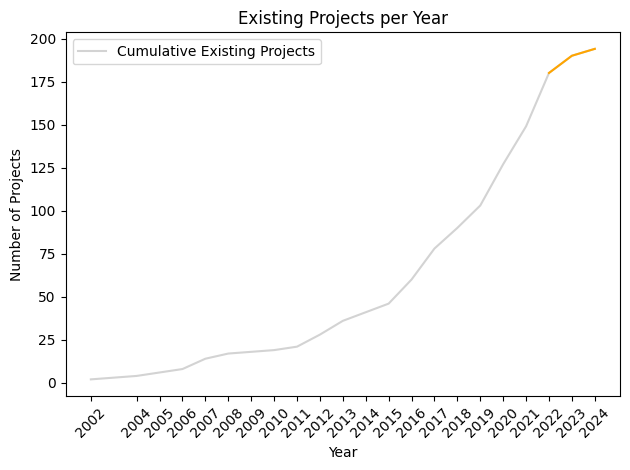

In [15]:
# 1) Create a filtered DataFrame that excludes 2025
df_filtered = df_years[df_years['Year'] != 2025].copy()

# 2) Calculate the "Existing" column on the filtered data
df_filtered['Existing'] = df_filtered.apply(
    lambda row: row['New'] - row['Unavailable'], axis=1
).cumsum()

# 3) Plot
fig, ax = plt.subplots()

ax.plot(
    df_filtered['Year'], 
    df_filtered['Existing'], 
    label='Cumulative Existing Projects', 
    color='lightgrey'
)

# Highlight the last 3 years in the filtered data
highlight_years = df_filtered.tail(3)
ax.plot(
    highlight_years['Year'], 
    highlight_years['Existing'], 
    color='orange'
)

# Basic labels and title
ax.set_title('Existing Projects per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Projects')

# Force the y-axis to use integer ticks
ax.yaxis.get_major_locator().set_params(integer=True)

# 4) Ensure we display *all* remaining years on the x-axis
ax.set_xticks(df_filtered['Year'])  
ax.set_xticklabels(df_filtered['Year'].astype(str), rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


In [16]:
unavailable_projects = data[(data[SITO_NON_TROVATO] == False) & (data[SITO_FUNZIONANTE] == False)].copy()
unavailable_projects.loc[:, 'Years_Existing'] = unavailable_projects.apply(
  lambda row: row['Year_Last_Seen'] - row['Year_First_Seen'] if pd.notna(row['Year_Last_Seen']) and pd.notna(row['Year_First_Seen']) else None, axis=1)

# Convert years to months
unavailable_projects.loc[:, 'Months_Existing'] = unavailable_projects['Years_Existing'] * 12
# Calculate the average months of availability
average_months_existing = unavailable_projects['Months_Existing'].dropna().mean()

# Convert average months to years and months
average_years_existing = average_months_existing // 12
average_remaining_months_existing = average_months_existing % 12

print(f"Average availability of currently unavailable projects: {average_years_existing:.0f} years and {average_remaining_months_existing:.0f} months")

Average availability of currently unavailable projects: 3 years and 9 months


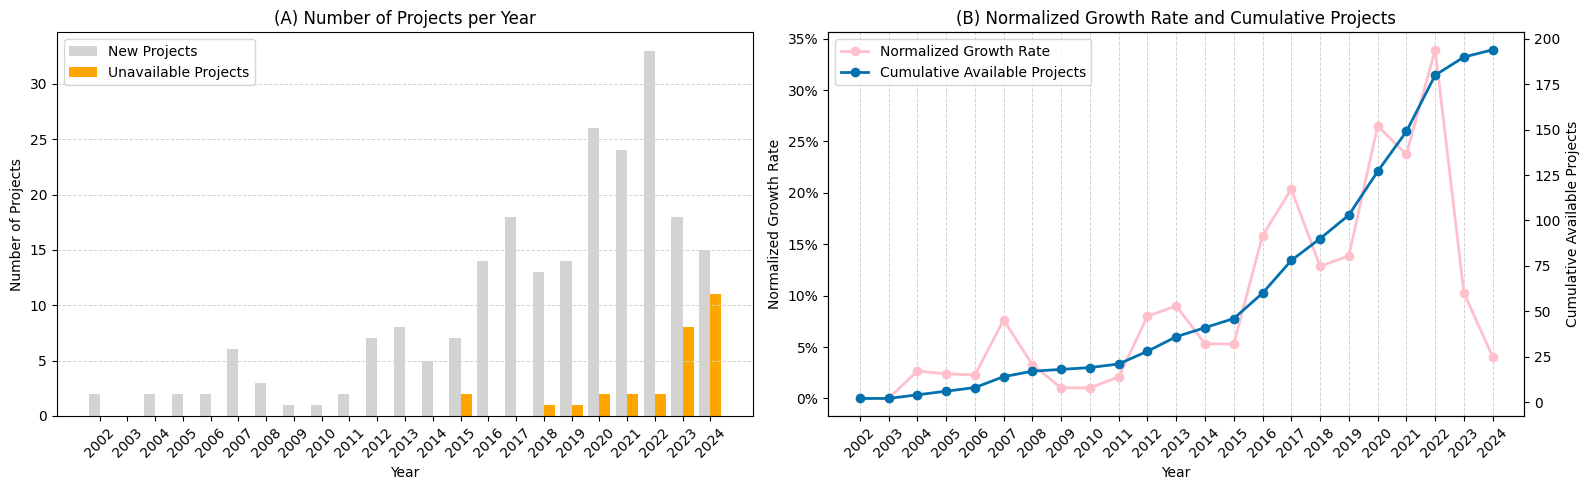

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ----------------------------------
# 1) Filter out 2025, sort by Year
# ----------------------------------
df_filtered = df_years[df_years['Year'] != 2025].copy()
df_filtered.sort_values(by='Year', inplace=True)

# Add year 2003 with 0 new and 0 unavailable projects
df_filtered = pd.concat([df_filtered, pd.DataFrame({'Year': [2003], 'New': [0], 'Unavailable': [0]})], ignore_index=True)
df_filtered.sort_values(by='Year', inplace=True)

# ----------------------------------
# 2) Compute Net_Diff and Total_Projects
# ----------------------------------
df_filtered['Net_Diff'] = df_filtered['New'] - df_filtered['Unavailable']
df_filtered['Total_Projects'] = df_filtered['Net_Diff'].cumsum()

# ----------------------------------
# 3) Compute Growth Rate divided by Total Projects
# ----------------------------------
prev = df_filtered['Total_Projects'].shift(1)
curr = df_filtered['Total_Projects']

# Standard growth rate (Arc method)
raw_growth_rate = ((curr - prev) / ((curr + prev) / 2)) * 100

# Normalize by Total_Projects
df_filtered['Normalized_Growth_Rate'] = raw_growth_rate * df_filtered['Total_Projects'] / 100

# Mask the first row (no meaningful growth rate for the first year)
df_filtered.loc[0, 'Normalized_Growth_Rate'] = None

# ----------------------------------
# 4) Plotting
# ----------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# (A) Plot Number of Projects on the left axis
xticks_positions = np.arange(len(df_filtered))  # Ensure proper alignment
bar_width = 0.4

ax1.bar(
  xticks_positions - bar_width / 2,  # Shift New bars to the left
  df_filtered['New'], 
  width=bar_width, 
  color='lightgrey', 
  label='New Projects'
)
ax1.bar(
  xticks_positions + bar_width / 2,  # Shift Unavailable bars to the right
  df_filtered['Unavailable'], 
  width=bar_width, 
  color='orange', 
  label='Unavailable Projects'
)
ax1.set_ylabel('Number of Projects')
ax1.set_xlabel('Year')
ax1.set_xticks(xticks_positions)
ax1.set_xticklabels(df_filtered['Year'].astype(str), rotation=45)
ax1.legend(loc='upper left')
ax1.set_title('(A) Number of Projects per Year')

# Add Y lines
for y in range(0, df_filtered['New'].max() + 1, 5):
    ax1.axhline(y=y, color='lightgrey', linestyle='--', linewidth=0.7)

# (B) Plot Growth Rate and Cumulative Projects on the right axis
ax3 = ax2.twinx()

line_growth, = ax2.plot(
  xticks_positions,
  df_filtered['Normalized_Growth_Rate'],
  color='pink',
  marker='o',
  linewidth=2,
  label='Normalized Growth Rate',
  zorder=5
)
ax2.set_ylabel('Normalized Growth Rate')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax2.set_xlabel('Year')
ax2.set_xticks(xticks_positions)
ax2.set_xticklabels(df_filtered['Year'].astype(str), rotation=45)

line_total, = ax3.plot(
  xticks_positions,
  df_filtered['Total_Projects'],
  color='#0371ad',
  marker='o',
  linewidth=2,
  label='Cumulative Available Projects',
  zorder=5
)
ax3.set_ylabel('Cumulative Available Projects')

# Add X lines
for x in xticks_positions:
    ax2.axvline(x=x, color='lightgrey', linestyle='--', linewidth=0.7)

# Single legend
all_handles = [
  line_growth,
  line_total
]
all_labels = [h.get_label() for h in all_handles]
ax3.legend(all_handles, all_labels, loc='upper left')

ax2.set_title('(B) Normalized Growth Rate and Cumulative Projects')

plt.tight_layout()
plt.show()
